---

# *Initial* **Setup**

---

## **Package** *Setup*

In [1]:
%pip install pydicom
%pip install ipywidgets
%pip install sde_lib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sde_lib (from versions: none)
ERROR: No matching distribution found for sde_lib


In [2]:
# Library Imports (General)
import pathlib
import os
import sys
import gc
import requests
import math
import random
import pickle
import argparse
import ipywidgets
import numpy as np
import pandas as pd

# Library Imports (Modelling)
import pydicom
import torch
import torch.nn as nn
import torchvision
import scipy

# Library Imports (Monitoring)
import matplotlib
import matplotlib.pyplot as plt
import time
import timeit
import warnings
import tqdm

In [3]:
# Function Imports (General)
from pathlib import Path
from ipywidgets import interactive, IntSlider

# Function Imports (Modelling)
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import transforms, utils

# Function Imports (Monitoring)
from PIL import Image


## **Argument** *Setup*

In [29]:
# Non-Conditional 3D Diffusion Model Parser Initialization
ncdiff_parser = argparse.ArgumentParser(
    description = "Non-Conditional 3D Diffusion Model")
ncdiff_parser.add_argument('--model_type', type = str,            # Chosen Model / Diffusion
                            choices =  {'video_diffusion',
                                        'blackout_diffusion',
                                        'gamma_diffusion'},
                            default = 'video_diffusion')
ncdiff_parser.add_argument('--model_version', type = int,         # Model Version Index
                            default = 0)
ncdiff_parser.add_argument('--data_version', type = int,          # Dataset Version Index
                            default = 1)
ncdiff_parser.add_argument('--noise_type', type = str,            # Diffusion Noise Distribution
                            default = 'gaussian')
settings = ncdiff_parser.parse_args("")

# ============================================================================================

# Directories and Path Arguments
ncdiff_parser.add_argument('--reader_folderpath', type = str,         # Path for Dataset Reader Directory
                            default = 'data/non_cond')
ncdiff_parser.add_argument('--public_data_folderpath', type = str,    # Path for Private Dataset Directory
                            default = "X:/nas-ctm01/datasets/public/MEDICAL/Duke-Breast-Cancer-T1")
                            #default = "../../../../../datasets/public/MEDICAL/Duke-Breast-Cancer-T1")
ncdiff_parser.add_argument( '--lung_data_folderpath', type = str,     # Path for LUCAS Dataset Directory
                            default = "X:/nas-ctm01/datasets/private/LUCAS/LCTSC")
                            #default = "X:/nas-ctm01/datasets/private/LUCAS/LIDC-3d/data/Image_4/LIDC-IDRI-0001_4.npy"
ncdiff_parser.add_argument('--private_data_folderpath', type = str,   # Path for Private Dataset Directory
                            default = "X:/nas-ctm01/datasets/private/METABREST/T1W_Breast")
                            #default = '../../../../../datasets/private/METABREST/T1W_Breast')

# Directory | Model-Related Path Arguments
ncdiff_parser.add_argument('--model_folderpath', type = str,          # Path for Model Architecture Directory
                            default = f'models/{settings.model_type}')
ncdiff_parser.add_argument('--script_folderpath', type = str,         # Path for Model Training & Testing Scripts Directory
                            default = f'scripts/{settings.model_type}')
ncdiff_parser.add_argument('--logs_folderpath', type = str,           # Path for Model Saving Directory
                            default = f'logs/{settings.model_type}')
    
# ============================================================================================

# Dataset | Dataset General Arguments
ncdiff_parser.add_argument('--data_format', type = str,           # Chosen Dataset Format for Reading
                            choices =  {'mp4', 'dicom'},
                            default = 'dicom')
ncdiff_parser.add_argument('--img_size', type = int,              # Generated Image Resolution
                            default = 512)
ncdiff_parser.add_argument('--num_slice', type = int,             # Number of 2D Slices in MRI
                            default = 150)
ncdiff_parser.add_argument('--data_prep', type = bool,            # Usage of Dataset Pre-Processing Control Value
                            default = True)
ncdiff_parser.add_argument('--h_flip', type = int,                # Percentage of Horizontally Flipped Subjects
                            default = 50)

# Dataset | Dataset Splitting Arguments
ncdiff_parser.add_argument('--train_subj', type = int,            # Number of Random Subjects in Training Set
                            default = 0)                          # PS: Input 0 for all Subjects in the Dataset
ncdiff_parser.add_argument('--val_subj', type = int,              # Number of Random Subjects in Validation Set
                            default = 0)
ncdiff_parser.add_argument('--test_subj', type = int,             # Number of Random Subjects in Test Set
                            default = 0)

# Dataset | DataLoader Arguments
ncdiff_parser.add_argument('--batch_size', type = int,            # DataLoader Batch Size Value
                            default = 1)
ncdiff_parser.add_argument('--shuffle', type = bool,              # DataLoader Subject Shuffling Control Value
                            default = True)
ncdiff_parser.add_argument('--num_workers', type = int,           # Number of DataLoader Workers
                            default = 8)
ncdiff_parser.add_argument('--num_fps', type = int,               # Number of Video Frames per Second
                            default = 4)

# ============================================================================================

# Model | Architecture-Defining Arguments
ncdiff_parser.add_argument('--seed', type = int,                  # Randomised Generational Seed
                            default = 0)
ncdiff_parser.add_argument('--dim', type = int,                   # Input Dimensionality (Not Necessary)
                            default = 64)
ncdiff_parser.add_argument('--num_channel', type = int,           # Number of Input Channels for Dataset
                            default = 1)
ncdiff_parser.add_argument('--mult_dim', type = tuple,            # Dimensionality for all Conditional Layers
                            default = (1, 2, 4, 8))

# Model | Training & Diffusion Arguments
#ncdiff_parser.add_argument('--num_epochs', type = int,            # Number of Training Epochs
#                            default = 30)
ncdiff_parser.add_argument('--num_ts', type = int,                # Number of Scheduler Timesteps
                            default = 300)
ncdiff_parser.add_argument('--num_steps', type = int,             # Number of Diffusion Training Steps
                            default = 500000)
ncdiff_parser.add_argument('--lr_base', type = float,             # Base Learning Rate Value
                            default = 1e-4)
ncdiff_parser.add_argument('--save_interval', type = int,         # Number of Training Step Interval inbetween Image Saving
                            default = 1000)
ncdiff_parser.add_argument('--save_img', type = int,              # Square Root of Number of Images Saved for Manual Evaluation
                            default = 2)

# ============================================================================================

settings = ncdiff_parser.parse_args("")
settings.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [4]:
# Non-Conditional 3D Blackout Diffusion Model Parser Initialization
blackout_diff_parser = argparse.ArgumentParser(
    description = "Non-Conditional 3D Blackout Diffusion Model")
blackout_diff_parser.add_argument(  '--model_type', type = str,            # Chosen Model / Diffusion
                                    choices =  {'video_diffusion',
                                                'blackout_diffusion',
                                                'gamma_diffusion'},
                                    default = 'blackout_diffusion')
blackout_diff_parser.add_argument(  '--model_version', type = int,         # Model Version Index
                                    default = 0)
blackout_diff_parser.add_argument(  '--data_version', type = int,          # Dataset Version Index
                                    default = 0)
settings = blackout_diff_parser.parse_args("")

# ============================================================================================

# Directories and Path Arguments
blackout_diff_parser.add_argument(  '--reader_folderpath', type = str,         # Path for Dataset Reader Directory
                                    default = 'data/non_cond')
blackout_diff_parser.add_argument(  '--public_data_folderpath', type = str,    # Path for Private Dataset Directory
                                    default = "X:/nas-ctm01/datasets/public/MEDICAL/Duke-Breast-Cancer-T1")
                                    #default = "../../datasets/public/MEDICAL/Duke-Breast-Cancer-T1")
blackout_diff_parser.add_argument(  '--lung_data_folderpath', type = str,      # Path for LUCAS Dataset Directory
                                    default = "X:\nas-ctm01\datasets\private\LUCAS\LCTSC")
blackout_diff_parser.add_argument(  '--private_data_folderpath', type = str,   # Path for Private Dataset Directory
                                    default = "X:/nas-ctm01/datasets/private/METABREST/T1W_Breast")
                                    #default = '../../datasets/private/METABREST/T1W_Breast')

# Directory | Model-Related Path Arguments
blackout_diff_parser.add_argument(  '--model_folderpath', type = str,          # Path for Model Architecture Directory
                                    default = f'models/{settings.model_type}')
blackout_diff_parser.add_argument(  '--script_folderpath', type = str,         # Path for Model Training & Testing Scripts Directory
                                    default = f'scripts/{settings.model_type}')
blackout_diff_parser.add_argument(  '--logs_folderpath', type = str,           # Path for Model Saving Directory
                                    default = f'logs/{settings.model_type}')
    
# ============================================================================================

# Dataset | Dataset General Arguments
blackout_diff_parser.add_argument(  '--img_size', type = int,              # Generated Image Resolution
                                    default = 64)
blackout_diff_parser.add_argument(  '--num_slice', type = int,             # Number of 2D Slices in MRI
                                    default = 30)
blackout_diff_parser.add_argument(  '--data_prep', type = bool,            # Usage of Dataset Pre-Processing Control Value
                                    default = True)
blackout_diff_parser.add_argument(  '--h_flip', type = int,                # Percentage of Horizontally Flipped Subjects
                                    default = 50)

# Dataset | Dataset Splitting Arguments
blackout_diff_parser.add_argument(  '--train_subj', type = int,            # Number of Random Subjects in Training Set
                                    default = 20)                          # PS: Input 0 for all Subjects in the Dataset
blackout_diff_parser.add_argument(  '--val_subj', type = int,              # Number of Random Subjects in Validation Set
                                    default = 0)
blackout_diff_parser.add_argument(  '--test_subj', type = int,             # Number of Random Subjects in Test Set
                                    default = 0)

# Dataset | DataLoader Arguments
blackout_diff_parser.add_argument(  '--batch_size', type = int,            # DataLoader Batch Size Value
                                    default = 1)
blackout_diff_parser.add_argument(  '--shuffle', type = bool,              # DataLoader Subject Shuffling Control Value
                                    default = False)
blackout_diff_parser.add_argument(  '--num_workers', type = int,           # Number of DataLoader Workers
                                    default = 8)

# ============================================================================================

# Model | Architecture-Defining Arguments
blackout_diff_parser.add_argument(  '--seed', type = int,                  # Randomised Generational Seed
                                    default = 0)
blackout_diff_parser.add_argument(  '--dim', type = int,                   # Input Dimensionality (Not Necessary)
                                    default = 64)
blackout_diff_parser.add_argument(  '--num_channel', type = int,           # Number of Input Channels for Dataset
                                    default = 1)
blackout_diff_parser.add_argument(  '--mult_dim', type = tuple,            # Dimensionality for all Conditional Layers
                                    default = (1, 2, 4, 8))

# Model | Diffusion Arguments
#blackout_diff_parser.add_argument('--num_epochs', type = int,            # Number of Training Epochs
#                            default = 30)
blackout_diff_parser.add_argument(  '--num_ts', type = int,                # Number of Scheduler Timesteps
                                    default = 1)
blackout_diff_parser.add_argument(  '--num_head', type = int,              # 
                                    default = 8)
blackout_diff_parser.add_argument(  '--num_bucker', type = int,            # 
                                    default = 32)
blackout_diff_parser.add_argument(  '--max_dist', type = int,              # 
                                    default = 128)
blackout_diff_parser.add_argument(  '--ts_end', type = float,              # 
                                    default = 10.)
blackout_diff_parser.add_argument(  '--offset', type = float,              # 
                                    default = 0.01)
blackout_diff_parser.add_argument(  '--noise_thresh', type = float,        # 
                                    default = 0.5)

# Model | Training Arguments
#blackout_diff_parser.add_argument('--num_epochs', type = int,            # Number of Training Epochs
#                                   default = 30)
blackout_diff_parser.add_argument(  '--num_steps', type = int,             # Number of Diffusion Training Steps
                                    default = 10000)
blackout_diff_parser.add_argument(  '--lr_base', type = float,             # Base Learning Rate Value
                                    default = 1e-3)
blackout_diff_parser.add_argument(  '--save_interval', type = int,         # Number of Training Step Interval inbetween Image Saving
                                    default = 1000)

# ============================================================================================

settings = blackout_diff_parser.parse_args("")
settings.device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


---

# *Dataset* **Access**

---

## *Dataset* **Utilities**

### **Raw** *Data*

In [135]:
# Control Station
patient_id = 26
patient_pos = 'OFP'
num_slice = 0

In [136]:
# Dataset Access
slice_list = os.listdir(f'{patient_pos}/ID{patient_id}')
data_filepath = f"{patient_pos}/ID{patient_id}/{slice_list[num_slice]}"
raw_data = pydicom.dcmread(data_filepath)
pixel_data = raw_data.pixel_array

# Meta Data Initialization
#meta_filepath = "ID1/S201-I-_PRIM_M_SE_T1W_TSE-20170324/annotFile_bkp.mat"
#meta_data = scipy.io.loadmat(meta_filepath)
#pixel_data = np.frombuffer(raw_data.PixelData)
#pixel_data = pydicom.data.get_testdata_file(data_filepath)

# Important Information Access
#assert(meta_data['cnt3dYXZ'].shape[2] == len(slice_filepath) - 1)
assert(pixel_data.shape[0] == raw_data.Rows)
assert(pixel_data.shape[1] == raw_data.Columns)
print(f"Patient Position: {str(raw_data[0x0018, 0x5100].value)}")
if patient_pos == 'External':
    print(f"Number of Slices: {int(len(slice_list))}")
    print(f"Slice Number: {int(raw_data[0x0020, 0x0013].value)}")
else:
    print(f"Number of Slices: {int(raw_data[0x2001, 0x1018].value)}")
    print(f"Slice Number: {int(raw_data[0x2001, 0x100a].value)}")
    print(f"Series Number: {int(raw_data.SeriesNumber)}")

#print(meta_data['cnt3dYXZ'].shape)
print(pixel_data.shape)
plt.imshow(pixel_data, cmap = plt.cm.binary)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'OFP/ID26'

In [143]:
# FFP vs OFP Comparison
ffp_list = os.listdir(f'FFP/ID{patient_id}'); ofp_list = os.listdir(f'OFP/ID{patient_id}')
ffp_filepath = f"FFP/ID{patient_id}/{ffp_list[num_slice]}"
ofp_filepath = f"OFP/ID{patient_id}/{ofp_list[num_slice]}"
ffp_data = pydicom.dcmread(ffp_filepath); ofp_data = pydicom.dcmread(ofp_filepath)
#ffp_pixel = ffp_data.pixel_array; ofp_pixel = ofp_data.pixel_array
print(f"Patient Positoning: {str(ffp_data[0x0018, 0x5100].value)} ; {str(ofp_data[0x0018, 0x5100].value)}\n\n" +\
                            "-------------------------------------------------------------------------\n")
for ffp, ofp in zip(ffp_data.iterall(), ofp_data.iterall()):
    if ffp != ofp: print(f"FFP: {ffp}\nOFP: {ofp}\n")


Patient Positoning: FFP ; FFP

-------------------------------------------------------------------------

FFP: (0008, 0012) Instance Creation Date              DA: '20170321'
OFP: (0008, 0012) Instance Creation Date              DA: '20170718'

FFP: (0008, 0013) Instance Creation Time              TM: '171934.980'
OFP: (0008, 0013) Instance Creation Time              TM: '175555.355'

FFP: (0008, 0018) SOP Instance UID                    UI: 1.3.46.670589.11.71641.5.0.1828.2017032116111778586
OFP: (0008, 0018) SOP Instance UID                    UI: 1.3.46.670589.11.71641.5.0.4680.2017071816470843561

FFP: (0008, 0020) Study Date                          DA: '20170321'
OFP: (0008, 0020) Study Date                          DA: '20170718'

FFP: (0008, 0021) Series Date                         DA: '20170321'
OFP: (0008, 0021) Series Date                         DA: '20170718'

FFP: (0008, 0022) Acquisition Date                    DA: '20170321'
OFP: (0008, 0022) Acquisition Date          

### *MRI* **Visualiser**

In [ ]:
# Image Visualizer
def mri_visualizer(
    num_slice: int = 0
):

    # Figure Initialization
    figure = plt.figure(figsize = (10, 10))
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.imshow(meta_data['cnt3dYXZ'][:, :, num_slice])#, cmap = meta_data['cmap'])

slice_slider = IntSlider(value = 0, min = 0,
    max = meta_data['cnt3dYXZ'].shape[2] - 1,
    description = 'Slice', continuous_update = False)
interactive(mri_visualizer, num_slice = slice_slider)
mri_visualizer(20)

In [9]:
# Single Image Visualizer
def mri_visualizer(
    num_slice: int = 0
):

    # Slice File Access
    slice_filepath = f"{patient_pos}/ID{patient_id}/{slice_list[num_slice]}"
    slice_data = pydicom.dcmread(slice_filepath)
    pixel_data = slice_data.pixel_array
    
    # Figure Initialization
    figure = plt.figure(figsize = (5, 5))
    plt.title(f"{str(slice_data[0x0018, 0x5100].value)} Position | " +\
              f"Slice #{int(slice_data[0x0020, 0x0013].value)} " +\
              f"out of {int(len(slice_list))}")
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.imshow(pixel_data, cmap = plt.cm.binary)

# Raw Data Access
slice_list = os.listdir(f'{patient_pos}/ID{patient_id}')
data_filepath = f"{patient_pos}/ID{patient_id}/{slice_list[0]}"
raw_data = pydicom.dcmread(data_filepath)
    
# Slice Visualizer Initialization
slice_slider = IntSlider(value = 0, min = 0,
    max = int(len(slice_list) - 1),
    description = 'Slice', continuous_update = True)
interactive(mri_visualizer, num_slice = slice_slider)
#mri_visualizer(20)

interactive(children=(IntSlider(value=0, description='Slice', max=59), Output()), _dom_classes=('widget-intera…

In [86]:
# Dual Image Visualizer
def mri_visualizer(
    num_slice: int = 0
):

    # Slice File Access
    ffp_filepath = f"FFP/ID{patient_id}/{ffp_list[num_slice]}"
    ofp_filepath = f"OFP/ID{patient_id}/{ofp_list[num_slice]}"
    ffp_data = pydicom.dcmread(ffp_filepath)
    ofp_data = pydicom.dcmread(ofp_filepath)
    ffp_pixel = ffp_data.pixel_array; ofp_pixel = ofp_data.pixel_array
    
    # Figure Initialization
    figure = plt.figure(figsize = (10, 5))
    plt.title(f"FFP | Slice #{int(ffp_data[0x2001, 0x100a].value)} " +\
              f"out of {int(ffp_data[0x2001, 0x1018].value)}")
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.subplot(1, 2, 1, title =    f"FFP | Slice #{int(ffp_data[0x2001, 0x100a].value)} " +\
                                    f"out of {int(ffp_data[0x2001, 0x1018].value)}")
    plt.imshow(ffp_pixel, cmap = plt.cm.binary)
    plt.subplot(1, 2, 2, title =    f"OFP | Slice #{int(ofp_data[0x2001, 0x100a].value)} " +\
                                    f"out of {int(ofp_data[0x2001, 0x1018].value)}")
    plt.imshow(ofp_pixel, cmap = plt.cm.binary)

# Raw Data Access
ffp_list = os.listdir(f'FFP/ID{patient_id}')
ofp_list = os.listdir(f'OFP/ID{patient_id}')
data_filepath = f"{patient_pos}/ID{patient_id}/{ffp_list[0]}"
raw_data = pydicom.dcmread(data_filepath)
    
# Slice Visualizer Initialization
slice_slider = IntSlider(value = 0, min = 0,
    max = int(raw_data[0x2001, 0x1018].value - 1),
    description = 'Slice', continuous_update = True)
interactive(mri_visualizer, num_slice = slice_slider)
#mri_visualizer(20)

interactive(children=(IntSlider(value=0, description='Slice', max=59), Output()), _dom_classes=('widget-intera…

### *Dataset* **Information**

In [20]:
# Non-Conditional MetaBrest Dataset Reader Class (V2)
class NCDataset(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        dataset: str = 'private',
        mode: str = 'train',
    ):  
        
        # Dataset Choice
        super(NCDataset).__init__(); self.settings = settings
        self.mode = mode; self.dataset = dataset
        if self.dataset == 'public': self.data_folderpath = self.settings.public_data_folderpath
        elif self.dataset == 'private': self.data_folderpath = self.settings.private_data_folderpath
        else: print("ERROR: Chosen Dataset / Directory does not exist!")
        
        # Subject Indexing (Existing or New Version)
        subj_listpath = Path(f"{self.settings.reader_folderpath}/V{self.settings.data_version}" +\
                             f"/{self.dataset}_{self.mode}_setV{self.settings.data_version}.txt")
        if subj_listpath.exists():
            print(f"Reading {self.dataset} Dataset Save Files for {self.mode} Set | Version {settings.data_version}")
            self.subj_list = subj_listpath.read_text().splitlines()
        else:
            print(f"Generating New Save Files for {self.dataset} Dataset | Version {settings.data_version}")
            self.subj_list = os.listdir(self.data_folderpath)       # Complete List of Subjects in Dataset
            self.subj_list = self.subj_split(self.subj_list)        # Selected List of Subjects in Dataset
        #assert len(self.subj_list) == self.num_subj, f"WARNING: Number of subjs does not match Dataset Version!"

        # --------------------------------------------------------------------------------------------
        
        # Dataset Transformations Initialization
        self.transform = transforms.Compose([
                                        transforms.Resize(( self.settings.img_size,
                                                            self.settings.img_size)),
                                        transforms.ToTensor()])
        self.h_flip = transforms.Compose([transforms.RandomHorizontalFlip(p = 1)])
        self.v_flip = transforms.Compose([transforms.RandomVerticalFlip(p = 1)])

    # ============================================================================================

    # DataLoader Length / No. Subjects Computation Functionality
    def __len__(self): return len(self.subj_list)
    
    # Subject Splitting Functionality
    def subj_split(self, subj_list: list):

        # Dataset Splitting
        train_subj = len(subj_list) if self.settings.train_subj == 0 else self.settings.train_subj
        assert 0 < (train_subj + self.settings.val_subj + self.settings.test_subj) <= len(subj_list),\
               f"ERROR: Dataset does not contain {train_subj + self.settings.val_subj + self.settings.test_subj} Subjects!"
        train_subj = np.sort(np.array(random.sample(subj_list, train_subj), dtype = 'str'))
        subj_list = [subj for subj in subj_list if subj not in train_subj]                                      # Training Set Splitting
        if self.settings.train_subj != 0:
            val_subj = np.sort(np.array(random.sample(subj_list, self.settings.val_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in val_subj]                                    # Validation Set Splitting
            test_subj = np.sort(np.array(random.sample(subj_list, self.settings.test_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in test_subj]                                   # Test Set Splitting
            subj_list = np.sort(np.array(subj_list, dtype = 'str'))
        assert len(subj_list) + len(train_subj) + self.settings.val_subj + self.settings.test_subj == len(self.subj_list),\
               f"ERROR: Dataset Splitting went Wrong!"

        # Dataset Split Saving
        if not os.path.isdir(f"V{self.settings.data_version}"): os.mkdir(f"V{self.settings.data_version}")
        if len(train_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_train_setV{self.settings.data_version}.txt", train_subj, fmt='%s')
        if len(subj_list) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_rest_set (V{self.settings.data_version}).txt", subj_list, fmt='%s')
        if self.settings.train_subj != 0:
            if len(val_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_val_setV{self.settings.data_version}.txt", val_subj, fmt='%s')
            if len(test_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_test_setV{self.settings.data_version}.txt", test_subj, fmt='%s')
        
    # ============================================================================================
        
    # Single Batch / Subject Generation Functionality
    def __getitem__(self, idx: int = 0 or str):
        
        # Subject Folder Access
        subj_idx = idx if type(idx) == str else self.subj_list[idx]
        subj_folderpath = f"{self.data_folderpath}/{subj_idx}"
        subj_filelist = os.listdir(subj_folderpath); i = 0
        while len(subj_filelist) > 0 and len(subj_filelist) <= 3:
            subj_folderpath = Path(f"{subj_folderpath}/{subj_filelist[0]}")
            subj_filelist = os.listdir(subj_folderpath)
        while os.path.splitext(f"{subj_folderpath}/{subj_filelist[i]}")[1] not in ['', '.dcm']: i += 1

        # Subject General Information Access
        #print(f"Accessing Subject {subj_idx}: {len(subj_filelist) - i} Slices")
        subj_filepath = Path((f"{subj_folderpath}/{subj_filelist[i]}"))
        subj_info = pydicom.dcmread(subj_filepath)
        subj_ori = subj_info[0x0020, 0x0037].value
        subj_v_flip = (np.all(subj_ori == [-1, 0, 0, 0, -1, 0]))
        subj_h_flip = (torch.rand(1) < (self.settings.h_flip / 100))
        num_row = subj_info.Rows; num_col = subj_info.Columns
        if self.dataset == 'private':
            num_slice = int(subj_info[0x2001, 0x1018].value)
            preg_status = int(subj_info[0x0010, 0x21c0].value)
        else:
            #num_slice = int(subj_info[0x0020, 0x1002].value)
            num_slice = None
            preg_status = None

        # --------------------------------------------------------------------------------------------
            
        # Subject Slice Data Access
        img_data = torch.empty((70, self.settings.img_size, self.settings.img_size)); slice_list = []
        for slice_filepath in subj_filelist:
            if os.path.splitext(slice_filepath)[1] in ['', '.dcm']:
                
                # Slice Data Access
                slice_filepath = Path(f"{subj_folderpath}/{slice_filepath}")
                slice_data = pydicom.dcmread(slice_filepath, force=True)
                slice_idx = int(slice_data[0x0020, 0x0013].value) - 1
                slice_list.append(slice_idx)
                img_slice = slice_data.pixel_array.astype(float)

                # Slice Image Pre-Processing | Rescaling, Resizing & Flipping
                if self.settings.data_prep:
                    img_slice = np.uint8((np.maximum(img_slice, 0) / img_slice.max()) * 255)
                    img_slice = Image.fromarray(img_slice).resize(( self.settings.img_size,
                                                                    self.settings.img_size)) 
                    if subj_h_flip: img_slice = self.h_flip(img_slice)
                    if subj_v_flip: img_slice = self.v_flip(img_slice)
                    img_slice = np.array(self.transform(img_slice))
                img_data[slice_idx, :, :] = torch.Tensor(img_slice); del img_slice
        img_data = img_data[np.sort(slice_list)]

        # --------------------------------------------------------------------------------------------
        
        # Correction for Chosen Number of Slices
        extra_slice = self.settings.num_slice - img_data.shape[0]
        if img_data.shape[0] < self.settings.num_slice:             # Addition of Repeated Peripheral Slices
            for extra in range(extra_slice):
                if extra % 2 == 0: img_data = torch.cat((img_data, img_data[-1].unsqueeze(0)), dim = 0)
                else: img_data = torch.cat((img_data[0].unsqueeze(0), img_data), dim = 0)
        elif img_data.shape[0] > self.settings.num_slice:           # Removal of Emptier Peripheral Slices
            img_data = img_data[int(np.ceil(-extra_slice / 2)) :\
                int(len(img_data) - np.floor(-extra_slice / 2))]
        #else: assert(num_slice == self.settings.num_slice)
          
        # Item Dictionary Returning
        #return img_data.unsqueeze(0)
        return {'img_data': img_data.unsqueeze(0),
                'resolution': f'[{num_row}, {num_col}]',
                'subj_info': subj_info, 'num_slice': num_slice,
                'preg_status': preg_status, 'orientation': subj_ori,
                'h_flip': subj_h_flip, 'v_flip': subj_v_flip,
                'position': str(subj_info[0x0018, 0x5100].value),
                'num_series': int(subj_info.SeriesNumber)}

# Dataset Initialization Example
public_dataset = NCDataset(settings,
                    mode = 'train',
                    dataset = 'public')
public_data = public_dataset.__getitem__('Breast_MRI_001')
private_dataset = NCDataset(settings,
                    mode = 'train',
                    dataset = 'private')
private_data = private_dataset.__getitem__('ID14')

Reading public Dataset Save Files for train Set | Version 1
Reading private Dataset Save Files for train Set | Version 1


In [16]:
public_data['subj_info']

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.33389863978639598148004524466314778584
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008, 0012) Instance Creation Date              DA: '19900101'
(0008, 0013) Instance Creation Time              TM: '084703.562000'
(0008, 0016) SOP Class UID   

In [21]:
private_data['subj_info']

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.46.670589.11.71641.5.0.3096.2017071008325597048
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.250.1.59.3.0.3.5.3
(0002, 0013) Implementation Version Name         SH: 'ETIAM_DCMTK_353'
(0002, 0016) Source Application Entity Title     AE: 'CDP5000'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']
(0008, 0012) Instance Creation Date              DA: '20170710'
(0008, 0013) Instance Creation Time              TM: '090759.007'
(0008, 0014) Instance 

In [19]:
meta_filepath = f"{settings.private_data_folderpath}/ID2/annotFile_bkp.mat"
meta_data = scipy.io.loadmat(meta_filepath)
meta_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Nov 07 12:12:35 2018',
 '__version__': '1.0',
 '__globals__': ['cnt3dYXZ', 'lineTRad', 'lineXYZT'],
 'cnt3dYXZ': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..

### *Dataset* to **MP4 Saver**

In [6]:
# Non-Conditional MetaBrest Dataset Reader Class (V2)
class NCDataset(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        dataset: str = 'private',
        mode: str = 'train',
    ):  
        
        # Dataset Choice
        super(NCDataset).__init__(); self.settings = settings
        self.mode = mode; self.dataset = dataset
        if self.dataset == 'public': self.data_folderpath = self.settings.public_data_folderpath
        elif self.dataset == 'lung': self.data_folderpath = self.settings.lung_data_folderpath
        elif self.dataset == 'private': self.data_folderpath = self.settings.private_data_folderpath
        else: print("ERROR: Chosen Dataset / Directory does not exist!")
        
        # Subject Indexing (Existing or New Version)
        subj_listpath = Path(f"{self.settings.reader_folderpath}/V{self.settings.data_version}" +\
                             f"/{self.dataset}_{self.mode}_setV{self.settings.data_version}.txt")
        if subj_listpath.exists():
            print(f"Reading {self.dataset} Dataset Save Files for {self.mode} Set | Version {settings.data_version}")
            self.subj_list = subj_listpath.read_text().splitlines()
        else:
            print(f"Generating New Save Files for {self.dataset} Dataset | Version {settings.data_version}")
            self.subj_list = os.listdir(self.data_folderpath)       # Complete List of Subjects in Dataset
            self.subj_list = self.subj_split(self.subj_list)        # Selected List of Subjects in Dataset
        #assert len(self.subj_list) == self.num_subj, f"WARNING: Number of subjs does not match Dataset Version!"

        # --------------------------------------------------------------------------------------------
        
        # Dataset Transformations Initialization
        self.transform = transforms.Compose([
                                        transforms.Resize(( self.settings.img_size,
                                                            self.settings.img_size)),
                                        transforms.ToTensor()])
        self.h_flip = transforms.Compose([transforms.RandomHorizontalFlip(p = 1)])
        self.v_flip = transforms.Compose([transforms.RandomVerticalFlip(p = 1)])

    # ============================================================================================

    # DataLoader Length / No. Subjects Computation Functionality
    def __len__(self): return len(self.subj_list)
    
    # Subject Splitting Functionality
    def subj_split(self, subj_list: list):

        # Dataset Splitting
        train_subj = len(subj_list) if self.settings.train_subj == 0 else self.settings.train_subj
        assert 0 < (train_subj + self.settings.val_subj + self.settings.test_subj) <= len(subj_list),\
               f"ERROR: Dataset does not contain {train_subj + self.settings.val_subj + self.settings.test_subj} Subjects!"
        train_subj = np.sort(np.array(random.sample(subj_list, train_subj), dtype = 'str'))
        subj_list = [subj for subj in subj_list if subj not in train_subj]                                      # Training Set Splitting
        if self.settings.train_subj != 0:
            val_subj = np.sort(np.array(random.sample(subj_list, self.settings.val_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in val_subj]                                    # Validation Set Splitting
            test_subj = np.sort(np.array(random.sample(subj_list, self.settings.test_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in test_subj]                                   # Test Set Splitting
            subj_list = np.sort(np.array(subj_list, dtype = 'str'))
        assert len(subj_list) + len(train_subj) + self.settings.val_subj + self.settings.test_subj == len(self.subj_list),\
               f"ERROR: Dataset Splitting went Wrong!"

        # Dataset Split Saving
        if not os.path.isdir(f"V{self.settings.data_version}"): os.mkdir(f"V{self.settings.data_version}")
        if len(train_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_train_setV{self.settings.data_version}.txt", train_subj, fmt='%s')
        if len(subj_list) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_rest_set (V{self.settings.data_version}).txt", subj_list, fmt='%s')
        if self.settings.train_subj != 0:
            if len(val_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_val_setV{self.settings.data_version}.txt", val_subj, fmt='%s')
            if len(test_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_test_setV{self.settings.data_version}.txt", test_subj, fmt='%s')
        
    # ============================================================================================
        
    # Single Batch / Subject Generation Functionality
    def __getitem__(self, idx: int = 0 or str):
        
        # Subject Folder Access
        subj_idx = idx if type(idx) == str else self.subj_list[idx]
        subj_folderpath = f"{self.data_folderpath}/{subj_idx}"
        subj_filelist = os.listdir(subj_folderpath); i = 0
        while len(subj_filelist) > 0 and len(subj_filelist) <= 3:
            subj_folderpath = Path(f"{subj_folderpath}/{subj_filelist[0]}")
            subj_filelist = os.listdir(subj_folderpath)
        while os.path.splitext(f"{subj_folderpath}/{subj_filelist[i]}")[1] not in ['', '.dcm']: i += 1

        # Subject General Information Access
        #print(f"Accessing Subject {subj_idx}: {len(subj_filelist) - i} Slices")
        subj_filepath = Path((f"{subj_folderpath}/{subj_filelist[i]}"))
        subj_info = pydicom.dcmread(subj_filepath)
        subj_ori = subj_info[0x0020, 0x0037].value
        subj_v_flip = (np.all(subj_ori == [-1, 0, 0, 0, -1, 0]))
        subj_h_flip = (torch.rand(1) < (self.settings.h_flip / 100))
        #num_row = subj_info.Rows; num_col = subj_info.Columns
        #if self.dataset == 'private':
            #num_slice = int(subj_info[0x2001, 0x1018].value)
            #preg_status = int(subj_info[0x0010, 0x21c0].value)
        #else:
            #num_slice = int(subj_info[0x0020, 0x1002].value)
            #preg_status = None

        # --------------------------------------------------------------------------------------------
            
        # Subject Slice Data Access
        img_data = torch.empty((70, self.settings.img_size, self.settings.img_size)); slice_list = []
        for slice_filepath in subj_filelist:
            if os.path.splitext(slice_filepath)[1] in ['', '.dcm']:
                
                # Slice Data Access
                slice_filepath = Path(f"{subj_folderpath}/{slice_filepath}")
                slice_data = pydicom.dcmread(slice_filepath, force=True)
                slice_idx = int(slice_data[0x0020, 0x0013].value) - 1
                slice_list.append(slice_idx)
                img_slice = slice_data.pixel_array.astype(float)

                # Slice Image Pre-Processing | Rescaling, Resizing & Flipping
                if self.settings.data_prep:
                    img_slice = np.uint8((np.maximum(img_slice, 0) / img_slice.max()) * 255)
                    img_slice = Image.fromarray(img_slice).resize(( self.settings.img_size,
                                                                    self.settings.img_size)) 
                    if subj_h_flip: img_slice = self.h_flip(img_slice)
                    if subj_v_flip: img_slice = self.v_flip(img_slice)
                    img_slice = np.array(self.transform(img_slice))
                img_data[slice_idx, :, :] = torch.Tensor(img_slice); del img_slice
        img_data = img_data[np.sort(slice_list)]

        # --------------------------------------------------------------------------------------------
        
        # Correction for Chosen Number of Slices
        extra_slice = self.settings.num_slice - img_data.shape[0]
        if img_data.shape[0] < self.settings.num_slice:             # Addition of Repeated Peripheral Slices
            for extra in range(extra_slice):
                if extra % 2 == 0: img_data = torch.cat((img_data, img_data[-1].unsqueeze(0)), dim = 0)
                else: img_data = torch.cat((img_data[0].unsqueeze(0), img_data), dim = 0)
        elif img_data.shape[0] > self.settings.num_slice:           # Removal of Emptier Peripheral Slices
            img_data = img_data[int(np.ceil(-extra_slice / 2)) :\
                int(len(img_data) - np.floor(-extra_slice / 2))]
        #else: assert(num_slice == self.settings.num_slice)
          
        # Item Dictionary Returning
        torchvision.io.write_video(f"{self.data_folderpath}/video_data/V{self.settings.data_version}/{self.mode}/{subj_idx}.mp4",
                                    img_data.unsqueeze(0).swapaxes(0, 3).swapaxes(0, 1).swapaxes(1, 2), fps = self.settings.num_fps)
        #return img_data.unsqueeze(0).swapaxes(0, 3)
        """return {'img_data': img_data,#.unsqueeze(0),
                'resolution': f'[{num_row}, {num_col}]',
                'subj_id': subj_idx, 'num_slice': num_slice,
                'preg_status': preg_status, 'orientation': subj_ori,
                'h_flip': subj_h_flip, 'v_flip': subj_v_flip,
                'position': str(subj_info[0x0018, 0x5100].value),
                'num_series': int(subj_info.SeriesNumber)}"""


In [8]:
# Dataset Saving Example
dataset = NCDataset(settings,
                    mode = 'train',
                    dataset = 'public')
dataset.__getitem__(0)
#for i in range(len(dataset)): dataset.__getitem__(i)

Reading public Dataset Save Files for train Set | Version 1


ValueError: Unexpected numpy array shape `(64, 64, 1)`

## *Dataset* **Reader**

In [14]:
# Non-Conditional MetaBrest Dataset Reader Class (V0)
class NCDataset(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        dataset: str = 'private',
        mode: str = 'train',
    ):  
        
        # Dataset Choice
        super(NCDataset).__init__(); self.settings = settings
        self.mode = mode; self.dataset = dataset
        if self.dataset == 'public': self.data_folderpath = self.settings.public_data_folderpath
        elif self.dataset == 'private': self.data_folderpath = self.settings.private_data_folderpath
        else: print("ERROR: Chosen Dataset / Directory does not exist!")
        
        # Subject Indexing (Existing or New Version)
        subj_listpath = Path(f"{self.settings.data_reader_folderpath}/V{self.settings.data_version}" +\
                             f"/{self.dataset}_{self.mode}_setV{self.settings.data_version}.txt")
        if subj_listpath.exists():
            print(f"Reading {self.dataset} Dataset Save Files for {self.mode} Set | Version {settings.data_version}")
            self.subj_list = subj_listpath.read_text().splitlines()
        else:
            print(f"Generating New Save Files for {self.dataset} Dataset | Version {settings.data_version}")
            self.subj_list = os.listdir(self.data_folderpath)       # Complete List of Subjects in Dataset

            self.subj_list = self.subj_split(self.subj_list)        # Selected List of Subjects in Dataset
        #assert len(self.subj_list) == self.num_subj, f"WARNING: Number of subjs does not match Dataset Version!"

        # --------------------------------------------------------------------------------------------
        
        # Dataset Transformations Initialization
        self.transform = transforms.Compose([   transforms.Resize(( self.settings.img_size,
                                                            self.settings.img_size)),
                                                transforms.ToTensor()])
        self.h_flip = transforms.Compose([      transforms.RandomHorizontalFlip(p = 1)])
        self.v_flip = transforms.Compose([      transforms.RandomVerticalFlip(p = 1)])

    # ============================================================================================

    # DataLoader Length / No. Subjects Computation Functionality
    def __len__(self): len(self.subj_list)
    
    # Subject Splitting Functionality
    def subj_split(self, subj_list: list):

        # Dataset Splitting
        assert 0 < (self.settings.train_subj + self.settings.val_subj + self.settings.test_subj) <= len(subj_list),\
               f"ERROR: Dataset does not contain {self.settings.train_subj + self.settings.val_subj + self.settings.test_subj} Subjects!"
        train_subj = np.sort(np.array(random.sample(subj_list, self.settings.train_subj), dtype = 'str'))
        subj_list = [subj for subj in subj_list if subj not in train_subj]                                  # Training Set Splitting
        val_subj = np.sort(np.array(random.sample(subj_list, self.settings.val_subj), dtype = 'str'))
        subj_list = [subj for subj in subj_list if subj not in val_subj]                                    # Validation Set Splitting
        test_subj = np.sort(np.array(random.sample(subj_list, self.settings.test_subj), dtype = 'str'))
        subj_list = [subj for subj in subj_list if subj not in test_subj]                                   # Test Set Splitting
        subj_list = np.sort(np.array(subj_list, dtype = 'str'))
        assert len(subj_list) + self.settings.train_subj + self.settings.val_subj + self.settings.test_subj == len(self.subj_list),\
               f"ERROR: Dataset Splitting went Wrong!"

        # Dataset Split Saving
        if not os.path.isdir(f"V{self.settings.data_version}"): os.mkdir(f"V{self.settings.data_version}")
        if len(train_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_train_setV{self.settings.data_version}.txt", train_subj, fmt='%s')
        if len(val_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_val_setV{self.settings.data_version}.txt", val_subj, fmt='%s')
        if len(test_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_test_setV{self.settings.data_version}.txt", test_subj, fmt='%s')
        if len(subj_list) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_rest_set (V{self.settings.data_version}).txt", subj_list, fmt='%s')
        
    # ============================================================================================
        
    # Single Batch / Subject Generation Functionality
    def __getitem__(self, idx: int = 0 or str):
        
        # Subject Folder Access
        subj_idx = idx if type(idx) == str else self.subj_list[idx]
        subj_folderpath = f"{self.data_folderpath}/{subj_idx}"
        subj_filelist = os.listdir(subj_folderpath); i = 0
        while len(subj_filelist) > 0 and len(subj_filelist) <= 3:
            subj_folderpath = Path(f"{subj_folderpath}/{subj_filelist[0]}")
            subj_filelist = os.listdir(subj_folderpath)
        
        while os.path.splitext(f"{subj_folderpath}/{subj_filelist[i]}")[1] not in ['', '.dcm']: i += 1

        # Subject General Information Access
        subj_filepath = Path((f"{subj_folderpath}/{subj_filelist[i]}"))
        subj_info = pydicom.dcmread(subj_filepath)
        subj_id = str(subj_info[0x0010, 0x0010].value)
        subj_ori = subj_info[0x0020, 0x0037].value
        subj_v_flip = (np.all(subj_ori == [-1, 0, 0, 0, -1, 0]))
        subj_h_flip = (torch.rand(1) < (self.settings.h_flip / 100))
        num_row = subj_info.Rows; num_col = subj_info.Columns
        if self.dataset == 'private':
            num_slice = int(subj_info[0x2001, 0x1018].value)
            preg_status = int(subj_info[0x0010, 0x21c0].value)
        else:
            num_slice = int(subj_info[0x0020, 0x1002].value)
            preg_status = None

        # --------------------------------------------------------------------------------------------
            
        # Subject Slice Data Access
        img_data = torch.empty((num_slice, self.settings.img_size, self.settings.img_size))
        for slice_filepath in subj_filelist:
            if os.path.splitext(slice_filepath)[1] in ['', '.dcm']:
                
                # Slice Data Access
                slice_filepath = Path(f"{subj_folderpath}/{slice_filepath}")
                slice_data = pydicom.dcmread(slice_filepath, force=True)
                slice_idx = int(slice_data[0x0020, 0x0013].value) - 1
                img_slice = slice_data.pixel_array.astype(float)

                # Slice Image Pre-Processing | Rescaling, Resizing & Flipping
                if self.settings.data_prep:
                    img_slice = np.uint8((np.maximum(img_slice, 0) / img_slice.max()) * 255)
                    img_slice = Image.fromarray(img_slice).resize(( self.settings.img_size,
                                                                    self.settings.img_size)) 
                    if subj_h_flip: img_slice = self.h_flip(img_slice)
                    if subj_v_flip: img_slice = self.v_flip(img_slice)
                    img_slice = np.array(self.transform(img_slice))
                img_data[slice_idx, :, :] = torch.Tensor(img_slice)

        # --------------------------------------------------------------------------------------------
        
        # Correction for Chosen Number of Slices
        extra_slice = self.settings.num_slice - num_slice
        if num_slice < self.settings.num_slice:             # Addition of Repeated Peripheral Slices
            for extra in range(extra_slice):
                if extra % 2 == 0: img_data = torch.cat((img_data, img_data[-1].unsqueeze(0)), dim = 0)
                else: img_data = torch.cat((img_data[0].unsqueeze(0), img_data), dim = 0)
        elif num_slice > self.settings.num_slice:           # Removal of Emptier Peripheral Slices
            img_data = img_data[int(np.ceil(-extra_slice / 2)) :\
                int(len(img_data) - np.floor(-extra_slice / 2))]
        else: assert(num_slice == self.settings.num_slice)
          
        # Item Dictionary Returning
        return {'img_data': img_data,#.unsqueeze(0),
                'resolution': f'[{num_row}, {num_col}]',
                'subj_id': subj_id, 'num_slice': num_slice,
                'preg_status': preg_status, 'orientation': subj_ori,
                'h_flip': subj_h_flip, 'v_flip': subj_v_flip,
                'position': str(subj_info[0x0018, 0x5100].value),
                'num_series': int(subj_info.SeriesNumber)}


In [6]:
# Non-Conditional MetaBrest Dataset Reader Class (V1)
class NCDataset(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        dataset: str = 'private',
        mode: str = 'train',
    ):  
        
        # Dataset Choice
        super(NCDataset).__init__(); self.settings = settings
        self.mode = mode; self.dataset = dataset
        if self.dataset == 'public': self.data_folderpath = self.settings.public_data_folderpath
        elif self.dataset == 'private': self.data_folderpath = self.settings.private_data_folderpath
        else: print("ERROR: Chosen Dataset / Directory does not exist!")
        
        # Subject Indexing (Existing or New Version)
        subj_listpath = Path(f"{self.settings.reader_folderpath}/V{self.settings.data_version}" +\
                             f"/{self.dataset}_{self.mode}_setV{self.settings.data_version}.txt")
        if subj_listpath.exists():
            print(f"Reading {self.dataset} Dataset Save Files for {self.mode} Set | Version {settings.data_version}")
            self.subj_list = subj_listpath.read_text().splitlines()
        else:
            print(f"Generating New Save Files for {self.dataset} Dataset | Version {settings.data_version}")
            self.subj_list = os.listdir(self.data_folderpath)       # Complete List of Subjects in Dataset
            self.subj_list = self.subj_split(self.subj_list)        # Selected List of Subjects in Dataset
        #assert len(self.subj_list) == self.num_subj, f"WARNING: Number of subjs does not match Dataset Version!"

        # --------------------------------------------------------------------------------------------
        
        # Dataset Transformations Initialization
        self.transform = transforms.Compose([
                                        transforms.Resize(( self.settings.img_size,
                                                            self.settings.img_size)),
                                        transforms.ToTensor()])
        self.h_flip = transforms.Compose([transforms.RandomHorizontalFlip(p = 1)])
        self.v_flip = transforms.Compose([transforms.RandomVerticalFlip(p = 1)])

    # ============================================================================================

    # DataLoader Length / No. Subjects Computation Functionality
    def __len__(self): return len(self.subj_list)
    
    # Subject Splitting Functionality
    def subj_split(self, subj_list: list):

        # Dataset Splitting
        assert 0 < (self.settings.train_subj + self.settings.val_subj + self.settings.test_subj) <= len(subj_list),\
               f"ERROR: Dataset does not contain {self.settings.train_subj + self.settings.val_subj + self.settings.test_subj} Subjects!"
        if self.settings.train_subj != 0:
            train_subj = np.sort(np.array(random.sample(subj_list, self.settings.train_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in train_subj]                                  # Training Set Splitting
            val_subj = np.sort(np.array(random.sample(subj_list, self.settings.val_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in val_subj]                                    # Validation Set Splitting
            test_subj = np.sort(np.array(random.sample(subj_list, self.settings.test_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in test_subj]                                   # Test Set Splitting
            subj_list = np.sort(np.array(subj_list, dtype = 'str'))
        else: train_subj = np.sort(np.array(subj_list, dtype = 'str'))
        assert len(subj_list) + self.settings.train_subj + self.settings.val_subj + self.settings.test_subj == len(self.subj_list),\
                                                                                            f"ERROR: Dataset Splitting went Wrong!"

        # Dataset Split Saving
        if not os.path.isdir(f"V{self.settings.data_version}"): os.mkdir(f"V{self.settings.data_version}")
        if len(train_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_train_setV{self.settings.data_version}.txt", train_subj, fmt='%s')
        if len(val_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_val_setV{self.settings.data_version}.txt", val_subj, fmt='%s')
        if len(test_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_test_setV{self.settings.data_version}.txt", test_subj, fmt='%s')
        if len(subj_list) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_rest_set (V{self.settings.data_version}).txt", subj_list, fmt='%s')
        
    # ============================================================================================
        
    # Single Batch / Subject Generation Functionality
    def __getitem__(self, idx: int = 0 or str):
        
        # Subject Folder Access
        subj_idx = idx if type(idx) == str else self.subj_list[idx]
        subj_folderpath = f"{self.data_folderpath}/{subj_idx}"
        subj_filelist = os.listdir(subj_folderpath); i = 0
        while len(subj_filelist) > 0 and len(subj_filelist) <= 3:
            while os.path.splitext(f"{subj_folderpath}/{subj_filelist[i]}")[1] not in ['', '.dcm']: i += 1
            subj_folderpath = Path(f"{subj_folderpath}/{subj_filelist[i]}")
            subj_filelist = os.listdir(subj_folderpath); i = 0
        while os.path.splitext(f"{subj_folderpath}/{subj_filelist[i]}")[1] not in ['', '.dcm']: i += 1

        # Subject General Information Access
        #print(f"Accessing Subject {subj_idx}: {len(subj_filelist) - i} Slices")
        subj_filepath = Path((f"{subj_folderpath}/{subj_filelist[i]}"))
        subj_info = pydicom.dcmread(subj_filepath)
        subj_ori = subj_info[0x0020, 0x0037].value
        subj_v_flip = (np.all(subj_ori == [-1, 0, 0, 0, -1, 0]))
        subj_h_flip = (torch.rand(1) < (self.settings.h_flip / 100))
        #num_row = subj_info.Rows; num_col = subj_info.Columns
        #if self.dataset == 'private':
            #num_slice = int(subj_info[0x2001, 0x1018].value)
            #preg_status = int(subj_info[0x0010, 0x21c0].value)
        #else:
            #num_slice = int(subj_info[0x0020, 0x1002].value)
            #preg_status = None

        # --------------------------------------------------------------------------------------------
            
        # Subject Slice Data Access
        img_data = torch.empty((70, self.settings.img_size, self.settings.img_size)); slice_list = []
        for slice_filepath in subj_filelist:
            if os.path.splitext(slice_filepath)[1] in ['', '.dcm']:
                
                # Slice Data Access
                slice_filepath = Path(f"{subj_folderpath}/{slice_filepath}")
                slice_data = pydicom.dcmread(slice_filepath, force=True)
                slice_idx = int(slice_data[0x0020, 0x0013].value) - 1
                slice_list.append(slice_idx)
                img_slice = slice_data.pixel_array.astype(float)

                # Slice Image Pre-Processing | Rescaling, Resizing & Flipping
                if self.settings.data_prep:
                    img_slice = np.uint8((np.maximum(img_slice, 0) / img_slice.max()) * 255)
                    img_slice = Image.fromarray(img_slice).resize(( self.settings.img_size,
                                                                    self.settings.img_size)) 
                    if subj_h_flip: img_slice = self.h_flip(img_slice)
                    if subj_v_flip: img_slice = self.v_flip(img_slice)
                    img_slice = np.array(self.transform(img_slice))
                img_data[slice_idx, :, :] = torch.Tensor(img_slice); del img_slice
        img_data = img_data[np.sort(slice_list)]

        # --------------------------------------------------------------------------------------------
        
        # Correction for Chosen Number of Slices
        extra_slice = self.settings.num_slice - img_data.shape[0]
        if img_data.shape[0] < self.settings.num_slice:             # Addition of Repeated Peripheral Slices
            for extra in range(extra_slice):
                if extra % 2 == 0: img_data = torch.cat((img_data, img_data[-1].unsqueeze(0)), dim = 0)
                else: img_data = torch.cat((img_data[0].unsqueeze(0), img_data), dim = 0)
        elif img_data.shape[0] > self.settings.num_slice:           # Removal of Emptier Peripheral Slices
            img_data = img_data[int(np.ceil(-extra_slice / 2)) :\
                int(len(img_data) - np.floor(-extra_slice / 2))]
        #else: assert(num_slice == self.settings.num_slice)
          
        # Item Dictionary Returning
        return img_data.unsqueeze(0)
        """return {'img_data': img_data,#.unsqueeze(0),
                'resolution': f'[{num_row}, {num_col}]',
                'subj_id': subj_id, 'num_slice': num_slice,
                'preg_status': preg_status, 'orientation': subj_ori,
                'h_flip': subj_h_flip, 'v_flip': subj_v_flip,
                'position': str(subj_info[0x0018, 0x5100].value),
                'num_series': int(subj_info.SeriesNumber)}"""


In [114]:
# Non-Conditional MetaBrest Dataset Reader Class (V2)
class NCDataset(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        dataset: str = 'private',
        mode: str = 'train',
    ):  
        
        # Dataset Choice
        super(NCDataset).__init__(); self.settings = settings
        self.mode = mode; self.dataset = dataset
        if self.dataset == 'public': self.data_folderpath = self.settings.public_data_folderpath
        elif self.dataset == 'private': self.data_folderpath = self.settings.private_data_folderpath
        else: print("ERROR: Chosen Dataset / Directory does not exist!")
        
        # Subject Indexing (Existing or New Version)
        subj_listpath = Path(f"{self.settings.reader_folderpath}/V{self.settings.data_version}" +\
                             f"/{self.dataset}_{self.mode}_setV{self.settings.data_version}.txt")
        if subj_listpath.exists():
            print(f"Reading {self.dataset} Dataset Save Files for {self.mode} Set | Version {settings.data_version}")
            self.subj_list = subj_listpath.read_text().splitlines()
        else:
            print(f"Generating New Save Files for {self.dataset} Dataset | Version {settings.data_version}")
            self.subj_list = os.listdir(self.data_folderpath)       # Complete List of Subjects in Dataset
            self.subj_list = self.subj_split(self.subj_list)        # Selected List of Subjects in Dataset
        #assert len(self.subj_list) == self.num_subj, f"WARNING: Number of subjs does not match Dataset Version!"

        # --------------------------------------------------------------------------------------------
        
        # Dataset Transformations Initialization
        self.transform = transforms.Compose([
                                        transforms.Resize(( self.settings.img_size,
                                                            self.settings.img_size)),
                                        transforms.ToTensor()])
        self.h_flip = transforms.Compose([transforms.RandomHorizontalFlip(p = 1)])
        self.v_flip = transforms.Compose([transforms.RandomVerticalFlip(p = 1)])

    # ============================================================================================

    # DataLoader Length / No. Subjects Computation Functionality
    def __len__(self): return len(self.subj_list)
    
    # Subject Splitting Functionality
    def subj_split(self, subj_list: list):

        # Dataset Splitting
        train_subj = len(subj_list) if self.settings.train_subj == 0 else self.settings.train_subj
        assert 0 < (train_subj + self.settings.val_subj + self.settings.test_subj) <= len(subj_list),\
               f"ERROR: Dataset does not contain {train_subj + self.settings.val_subj + self.settings.test_subj} Subjects!"
        train_subj = np.sort(np.array(random.sample(subj_list, train_subj), dtype = 'str'))
        subj_list = [subj for subj in subj_list if subj not in train_subj]                                      # Training Set Splitting
        if self.settings.train_subj != 0:
            val_subj = np.sort(np.array(random.sample(subj_list, self.settings.val_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in val_subj]                                    # Validation Set Splitting
            test_subj = np.sort(np.array(random.sample(subj_list, self.settings.test_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in test_subj]                                   # Test Set Splitting
            subj_list = np.sort(np.array(subj_list, dtype = 'str'))
        assert len(subj_list) + len(train_subj) + self.settings.val_subj + self.settings.test_subj == len(self.subj_list),\
               f"ERROR: Dataset Splitting went Wrong!"

        # Dataset Split Saving
        if not os.path.isdir(f"V{self.settings.data_version}"): os.mkdir(f"V{self.settings.data_version}")
        if len(train_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_train_setV{self.settings.data_version}.txt", train_subj, fmt='%s')
        if len(subj_list) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_rest_set (V{self.settings.data_version}).txt", subj_list, fmt='%s')
        if self.settings.train_subj != 0:
            if len(val_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_val_setV{self.settings.data_version}.txt", val_subj, fmt='%s')
            if len(test_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_test_setV{self.settings.data_version}.txt", test_subj, fmt='%s')
        
    # ============================================================================================
        
    # Single Batch / Subject Generation Functionality
    def __getitem__(self, idx: int = 0 or str):
        
        # Subject Folder Access
        subj_idx = idx if type(idx) == str else self.subj_list[idx]
        subj_folderpath = f"{self.data_folderpath}/{subj_idx}"
        subj_filelist = os.listdir(subj_folderpath); i = 0
        while len(subj_filelist) > 0 and len(subj_filelist) <= 3:
            subj_folderpath = Path(f"{subj_folderpath}/{subj_filelist[0]}")
            subj_filelist = os.listdir(subj_folderpath)
        while os.path.splitext(f"{subj_folderpath}/{subj_filelist[i]}")[1] not in ['', '.dcm']: i += 1

        # Subject General Information Access
        #print(f"Accessing Subject {subj_idx}: {len(subj_filelist) - i} Slices")
        subj_filepath = Path((f"{subj_folderpath}/{subj_filelist[i]}"))
        subj_info = pydicom.dcmread(subj_filepath)
        subj_ori = subj_info[0x0020, 0x0037].value
        subj_v_flip = (np.all(subj_ori == [-1, 0, 0, 0, -1, 0]))
        subj_h_flip = (torch.rand(1) < (self.settings.h_flip / 100))
        #num_row = subj_info.Rows; num_col = subj_info.Columns
        #if self.dataset == 'private':
            #num_slice = int(subj_info[0x2001, 0x1018].value)
            #preg_status = int(subj_info[0x0010, 0x21c0].value)
        #else:
            #num_slice = int(subj_info[0x0020, 0x1002].value)
            #preg_status = None

        # --------------------------------------------------------------------------------------------
            
        # Subject Slice Data Access
        img_data = torch.empty((70, self.settings.img_size, self.settings.img_size)); slice_list = []
        for slice_filepath in subj_filelist:
            if os.path.splitext(slice_filepath)[1] in ['', '.dcm']:
                
                # Slice Data Access
                slice_filepath = Path(f"{subj_folderpath}/{slice_filepath}")
                slice_data = pydicom.dcmread(slice_filepath, force=True)
                slice_idx = int(slice_data[0x0020, 0x0013].value) - 1
                slice_list.append(slice_idx)
                img_slice = slice_data.pixel_array.astype(float)

                # Slice Image Pre-Processing | Rescaling, Resizing & Flipping
                if self.settings.data_prep:
                    img_slice = np.uint8((np.maximum(img_slice, 0) / img_slice.max()) * 255)
                    img_slice = Image.fromarray(img_slice).resize(( self.settings.img_size,
                                                                    self.settings.img_size)) 
                    if subj_h_flip: img_slice = self.h_flip(img_slice)
                    if subj_v_flip: img_slice = self.v_flip(img_slice)
                    img_slice = np.array(self.transform(img_slice))
                img_data[slice_idx, :, :] = torch.Tensor(img_slice); del img_slice
        img_data = img_data[np.sort(slice_list)]

        # --------------------------------------------------------------------------------------------
        
        # Correction for Chosen Number of Slices
        extra_slice = self.settings.num_slice - img_data.shape[0]
        if img_data.shape[0] < self.settings.num_slice:             # Addition of Repeated Peripheral Slices
            for extra in range(extra_slice):
                if extra % 2 == 0: img_data = torch.cat((img_data, img_data[-1].unsqueeze(0)), dim = 0)
                else: img_data = torch.cat((img_data[0].unsqueeze(0), img_data), dim = 0)
        elif img_data.shape[0] > self.settings.num_slice:           # Removal of Emptier Peripheral Slices
            img_data = img_data[int(np.ceil(-extra_slice / 2)) :\
                int(len(img_data) - np.floor(-extra_slice / 2))]
        #else: assert(num_slice == self.settings.num_slice)
          
        # Item Dictionary Returning
        return img_data.unsqueeze(0)
        """return {'img_data': img_data,#.unsqueeze(0),
                'resolution': f'[{num_row}, {num_col}]',
                'subj_id': subj_id, 'num_slice': num_slice,
                'preg_status': preg_status, 'orientation': subj_ori,
                'h_flip': subj_h_flip, 'v_flip': subj_v_flip,
                'position': str(subj_info[0x0018, 0x5100].value),
                'num_series': int(subj_info.SeriesNumber)}"""


In [30]:
# Non-Conditional MetaBrest Dataset Reader Class (V3)
class NCDataset(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        dataset: str = 'private',
        mode: str = 'train',
    ):  
        
        # Dataset Choice
        super(NCDataset).__init__(); self.settings = settings
        self.mode = mode; self.dataset = dataset
        if self.dataset == 'public': self.data_folderpath = self.settings.public_data_folderpath
        elif self.dataset == 'lung': self.data_folderpath = self.settings.lung_data_folderpath
        elif self.dataset == 'private': self.data_folderpath = self.settings.private_data_folderpath
        else: print("ERROR: Chosen Dataset / Directory does not exist!")
        
        # Subject Indexing (Existing or New Version)
        subj_listpath = Path(f"{self.settings.reader_folderpath}/V{self.settings.data_version}" +\
                             f"/{self.dataset}_{self.mode}_setV{self.settings.data_version}.txt")
        if subj_listpath.exists():
            print(f"Reading {self.dataset} Dataset Save Files for {self.mode} Set | Version {settings.data_version}")
            self.subj_list = subj_listpath.read_text().splitlines()
        else:
            print(f"Generating New Save Files for {self.dataset} Dataset | Version {settings.data_version}")
            self.subj_list = os.listdir(self.data_folderpath)       # Complete List of Subjects in Dataset
            if self.dataset != 'lung': self.subj_list.remove('video_data')
            self.subj_list = self.subj_split(self.subj_list)        # Selected List of Subjects in Dataset
        #assert len(self.subj_list) == self.num_subj, f"WARNING: Number of subjs does not match Dataset Version!"

        # --------------------------------------------------------------------------------------------
        
        # Dataset Transformations Initialization
        self.transform = transforms.Compose([
                                        transforms.Resize(( self.settings.img_size,
                                                            self.settings.img_size)),
                                        transforms.ToTensor()])
        self.h_flip = transforms.Compose([transforms.RandomHorizontalFlip(p = 1)])
        self.v_flip = transforms.Compose([transforms.RandomVerticalFlip(p = 1)])

    # ============================================================================================

    # DataLoader Length / No. Subjects Computation Functionality
    def __len__(self): return len(self.subj_list)
    
    # Subject Splitting Functionality
    def subj_split(self, subj_list: list):

        # Dataset Splitting
        train_subj = len(subj_list) if self.settings.train_subj == 0 else self.settings.train_subj
        assert 0 < (train_subj + self.settings.val_subj + self.settings.test_subj) <= len(subj_list),\
               f"ERROR: Dataset does not contain {train_subj + self.settings.val_subj + self.settings.test_subj} Subjects!"
        train_subj = np.sort(np.array(random.sample(subj_list, train_subj), dtype = 'str'))
        subj_list = [subj for subj in subj_list if subj not in train_subj]                                      # Training Set Splitting
        if self.settings.train_subj != 0:
            val_subj = np.sort(np.array(random.sample(subj_list, self.settings.val_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in val_subj]                                    # Validation Set Splitting
            test_subj = np.sort(np.array(random.sample(subj_list, self.settings.test_subj), dtype = 'str'))
            subj_list = [subj for subj in subj_list if subj not in test_subj]                                   # Test Set Splitting
            subj_list = np.sort(np.array(subj_list, dtype = 'str'))
        assert len(subj_list) + len(train_subj) + self.settings.val_subj + self.settings.test_subj == len(self.subj_list),\
               f"ERROR: Dataset Splitting went Wrong!"

        # Dataset Split Saving
        if not os.path.isdir(f"V{self.settings.data_version}"): os.mkdir(f"V{self.settings.data_version}")
        if len(train_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_train_setV{self.settings.data_version}.txt", train_subj, fmt='%s')
        if len(subj_list) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_rest_setV{self.settings.data_version}.txt", subj_list, fmt='%s')
        if self.settings.train_subj != 0:
            if len(val_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_val_setV{self.settings.data_version}.txt", val_subj, fmt='%s')
            if len(test_subj) != 0: np.savetxt(f"V{self.settings.data_version}/{self.dataset}_test_setV{self.settings.data_version}.txt", test_subj, fmt='%s')
        
    # ============================================================================================
        
    # Single Batch / Subject Generation Functionality
    def __getitem__(self, idx: int = 0 or str, save: bool = False):
        subj_idx = idx if type(idx) == str else self.subj_list[idx]
        if self.settings.data_format == 'mp4':

            # Subject Data Access
            subj_folderpath = f"{self.data_folderpath}/video_data/V{self.settings.data_version}/{self.mode}/{subj_idx}.mp4"
            img_data = (torchvision.io.read_video(subj_folderpath, pts_unit = 'sec')[0][:, :, :, 0] / 255.0).type(torch.float32)

        elif self.settings.data_format == 'dicom':

            # Subject Folder Access
            subj_folderpath = f"{self.data_folderpath}/{subj_idx}"
            subj_filelist = os.listdir(subj_folderpath); i = 0
            while len(subj_filelist) > 0 and len(subj_filelist) <= 3:
                subj_folderpath = Path(f"{subj_folderpath}/{subj_filelist[-1]}")
                subj_filelist = os.listdir(subj_folderpath)
            while os.path.splitext(f"{subj_folderpath}/{subj_filelist[i]}")[1] not in ['', '.dcm']: i += 1

            # Subject General Information Access
            #print(f"Accessing Subject {subj_idx}: {len(subj_filelist) - i} Slices")
            subj_filepath = Path((f"{subj_folderpath}/{subj_filelist[i]}"))
            subj_info = pydicom.dcmread(subj_filepath)
            subj_ori = subj_info[0x0020, 0x0037].value
            subj_v_flip = (np.all(subj_ori == [-1, 0, 0, 0, -1, 0]))
            subj_h_flip = (torch.rand(1) < (self.settings.h_flip / 100))
            #num_row = subj_info.Rows; num_col = subj_info.Columns
            #if self.dataset == 'private':
                #num_slice = int(subj_info[0x2001, 0x1018].value)
                #preg_status = int(subj_info[0x0010, 0x21c0].value)
            #else:
                #num_slice = int(subj_info[0x0020, 0x1002].value)
                #preg_status = None

            # --------------------------------------------------------------------------------------------
                
            # Subject Slice Data Access
            og_frame = 200 if self.dataset == 'lung' else 100
            img_data = torch.empty((og_frame, self.settings.img_size, self.settings.img_size)); slice_list = []
            for slice_filepath in subj_filelist:
                if os.path.splitext(slice_filepath)[1] in ['', '.dcm']:
                    
                    # Slice Data Access
                    slice_filepath = Path(f"{subj_folderpath}/{slice_filepath}")
                    slice_data = pydicom.dcmread(slice_filepath, force = True)
                    slice_idx = int(slice_data[0x0020, 0x0013].value) - 1
                    #print(slice_idx)
                    slice_list.append(slice_idx)
                    img_slice = slice_data.pixel_array.astype(float)

                    # Slice Image Pre-Processing | Rescaling, Resizing & Flipping
                    if self.settings.data_prep:
                        img_slice = np.uint8((np.maximum(img_slice, 0) / img_slice.max()) * 255)
                        img_slice = Image.fromarray(img_slice).resize(( self.settings.img_size,
                                                                        self.settings.img_size)) 
                        if subj_h_flip: img_slice = self.h_flip(img_slice)
                        if subj_v_flip: img_slice = self.v_flip(img_slice)
                        img_slice = np.array(self.transform(img_slice))
                    img_data[slice_idx, :, :] = torch.Tensor(img_slice); del img_slice
            img_data = img_data[np.sort(slice_list)]

            # --------------------------------------------------------------------------------------------
            
            # Correction for Chosen Number of Slices
            extra_slice = self.settings.num_slice - img_data.shape[0]
            if img_data.shape[0] < self.settings.num_slice:             # Addition of Repeated Peripheral Slices
                for extra in range(extra_slice):
                    if extra % 2 == 0: img_data = torch.cat((img_data, img_data[-1].unsqueeze(0)), dim = 0)
                    else: img_data = torch.cat((img_data[0].unsqueeze(0), img_data), dim = 0)
            elif img_data.shape[0] > self.settings.num_slice:           # Removal of Emptier Peripheral Slices
                img_data = img_data[int(np.ceil(-extra_slice / 2)) :\
                    int(len(img_data) - np.floor(-extra_slice / 2))]
            #else: assert(num_slice == self.settings.num_slice)
          
            # Item Dictionary Returning
            if save:
                print(f"Saving Patient Data for {subj_idx} into Video Format")
                torchvision.io.write_video(f"{self.data_folderpath}/video_data/V{self.settings.data_version}/{self.mode}/{subj_idx}.mp4",
                    (img_data.unsqueeze(3).repeat(1, 1, 1, 3) * 255).type(torch.uint8), fps = self.settings.num_fps)
        else: raise(NotImplementedError)
        return img_data.unsqueeze(0)
    
        """return {'img_data': img_data,#.unsqueeze(0),
                'resolution': f'[{num_row}, {num_col}]',
                'subj_id': subj_id, 'num_slice': num_slice,
                'preg_status': preg_status, 'orientation': subj_ori,
                'h_flip': subj_h_flip, 'v_flip': subj_v_flip,
                'position': str(subj_info[0x0018, 0x5100].value),
                'num_series': int(subj_info.SeriesNumber)}"""


Generating New Save Files for lung Dataset | Version 1
torch.Size([1, 150, 512, 512])


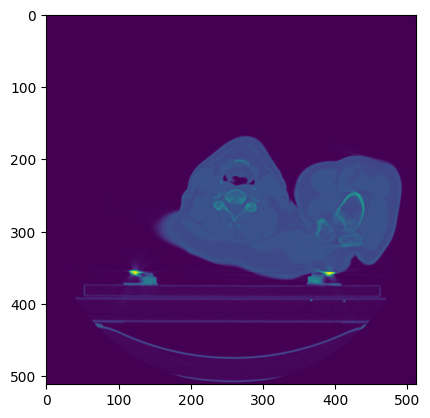

In [31]:
# Dataset Initialization Example
dataset = NCDataset(settings,
                    mode = 'train',
                    dataset = 'lung')
data = dataset.__getitem__('LCTSC-Test-S1-103')
print(data.shape)
plt.imshow(data[0, 20])

In [32]:
# Single 3D Image Visualizer
def mri_visualizer(
    num_slice: int = 0
):
    
    # Figure Initialization
    figure = plt.figure(figsize = (5, 5)); plt.title(f"Slice #{num_slice}")
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.imshow(data[0][num_slice - 1], cmap = plt.cm.binary)
    
# Slice Visualizer Initialization
slice_slider = IntSlider(   value = 1, min = 1,
                            max = settings.num_slice,
    description = 'Slice', continuous_update = True)
interactive(mri_visualizer, num_slice = slice_slider)
#mri_visualizer(20)

interactive(children=(IntSlider(value=1, description='Slice', max=150, min=1), Output()), _dom_classes=('widge…

In [41]:
filepath = "X:/nas-ctm01/datasets/private/LUCAS/LIDC-IDRI-Preprocessing/data/Image_corr/LIDC-IDRI-0001"
subj_filelist = os.listdir(filepath)
img = torch.empty((1, len(subj_filelist), 512, 512))
for i, slice_filepath in enumerate(subj_filelist):
    img[0, i, :, :] = torch.Tensor(np.load(f"{filepath}/{slice_filepath}"))


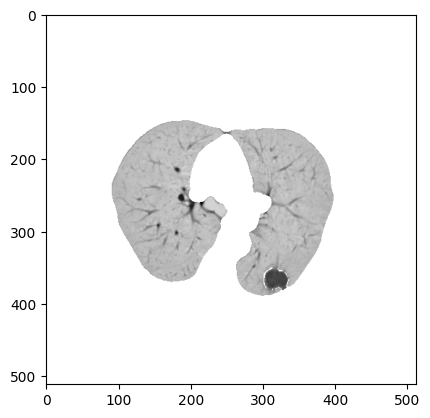

In [46]:
plt.imshow(img[0, 2], cmap = plt.cm.binary)

---

# **Video** *Diffusion*

---

## **Evaluation** *Metrics*

**Fréchet Inception Distance Score** (*FID Score*)

- https://lightning.ai/docs/torchmetrics/stable/image/frechet_inception_distance.html
- https://pytorch.org/torcheval/main/generated/torcheval.metrics.FrechetInceptionDistance.html
- https://github.com/mseitzer/pytorch-fid/tree/master

**3D Structural Similarity Index** (*3D SSIM Index*)

- https://github.com/jinh0park/pytorch-ssim-3D/tree/master

**Sorensen-Dice Coefficient** (*Dice Score*)

- https://medium.com/@saba99/dice-or-dice-score-fa9f70422db4
- https://copyprogramming.com/howto/dice-coefficient-image-segmentation-python

**Inception Score** (*IS Loss*)

- https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/
- https://kailashahirwar.medium.com/a-very-short-introduction-to-inception-score-is-c9b03a7dd788

**Normalized Mutual Information** (*NMI Loss*)

**Peak Signal-to-Noise Ratio** (*PSNR Loss*)

- https://scikit-image.org/docs/stable/api/skimage.metrics.html

In [5]:
# FID Score Requisites
%pip install torchmetrics
%pip install torch-fidelity
%pip install torchmetrics[image]
from torchmetrics.image.fid import FrechetInceptionDistance as FID

# 3D SSIM Index Requisites (Pip Package)
#%pip install pytorch_ssim
#import pytorch_ssim
#from pytorch_ssim import ssim3D

# 3D SSIM Index Requisites (Local Package)
sys.path.append('eval')
from ssim3d_metric import ssim3D

"""
# Inception Score Requisites
import keras
from keras.applications.inception_v3 import preprocess_input, InceptionV3
%pip install opencv-python
import cv2
"""

# Dice Score, PSNR  Requisites

%pip install scikit-image
import skimage
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import normalized_mutual_information as NMI
from skimage.filters import threshold_li


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\sousa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\sousa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\sousa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'ssim3d_metric'

In [16]:
# Single Dice Score Functionality
def dice_score(input_img, gen_img):

    # Image Binarization (Li's Method)
    #x_thresh, x = cv2.threshold(x, 128, 192, cv2.THRESH_OTSU)
    #y_thresh, y = cv2.threshold(y, 128, 192, cv2.THRESH_OTSU)
    input_img = input_img > threshold_li(input_img)
    gen_img = gen_img > threshold_li(gen_img)
    #print(x_thresh, y_thresh)

    # Dice Score Computation
    intersect = np.sum(input_img * gen_img)
    if (np.sum(input_img) == 0) and (np.sum(gen_img) == 0): return 1
    return (2 * intersect) / (np.sum(input_img) + np.sum(gen_img))

# Mean Dice Score Functionality
def mean_dice_score(input_img, gen_img):
    assert(np.all(input_img.shape == gen_img.shape)); mean_score = 0.
    if type(input_img) == torch.Tensor:
        input_img = input_img.numpy(); gen_img = gen_img.numpy()
    for i in range(input_img.shape[0]):
        for j in range(input_img.shape[1]):
            score = dice_score(input_img[i, j, :, :], gen_img[i, j, :, :])
            mean_score += score / (input_img.shape[1] * input_img.shape[0])
    return mean_score

In [17]:
# Inception Score Functionality (WIP)
def inception_score(
    inception_model,
    gen_img,
    num_split: int = 10,
    eps: float = 1e-16
):

    # Inception Score Computation
    y_hat = inception_model.predict(gen_img); is_score = list()
    num_part = np.floor(gen_img.shape[0] / num_split)
    for i in range(num_split):
        idx_start, idx_end = i * num_part, (i * num_part) + num_part
        prob_yx = y_hat[idx_start : idx_end]
        prob_y = np.expand_dims(prob_yx.mean(axis = 0), 0)
        kld_div = prob_yx * (np.log(prob_yx + eps) - np.log(prob_y + eps))
        is_score.append(np.exp(np.mean(kld_div.sum(axis = 1))))
    return np.mean(is_score), np.std(is_score)

In [21]:
# FID Score Computation Example
img1 = torch.randint(0, 200, (100, 3, 299, 299), dtype = torch.uint8)
img2 = torch.randint(100, 255, (100, 3, 299, 299), dtype = torch.uint8)
fid_metric = FID(feature = 64)
fid_metric.update(img1, real = True)
fid_metric.update(img2, real = False)
print(f"FID Score: {fid_metric.compute()}")

# 3D SSIM Index Computation Example
img1 = torch.randn(1, 1, 30, 64, 64)
img2 = torch.randn(1, 1, 30, 64, 64)
print(f"3D SSIM Index: {ssim3D(img1, img2)}")

# Binarization and Dice Score Computation Example
img1 = torch.randn(1, 30, 64, 64)
img2 = torch.randn(1, 30, 64, 64)
print(f"Dice Score: {mean_dice_score(img1, img2)}")

"""
# Inception Score Computation Example (WIP)
img2 = torch.randn(1, 64, 64, 3)
inception_model = InceptionV3()
is_mean, is_std = inception_score(inception_model, img2)
print(f"Inception Score: {is_mean} +- {is_std}")
"""

#NMI & PSNR Loss Computation Examples
img1 = torch.randn(1, 30, 64, 64).numpy()
img2 = torch.randn(1, 30, 64, 64).numpy()
img1 -= img1.min(1, keepdim=True)[0]
img1 /= img1.max(1, keepdim=True)[0]
img2 -= img2.min(1, keepdim=True)[0]
img2 /= img2.max(1, keepdim=True)[0]
print(f"PSNR Loss: {PSNR(img1, img2)}")
print(f"NMI Loss: {NMI(img1, img2)}")

FID Score: 12.622090339660645
3D SSIM Index: 0.002742826472967863
Dice Score: 0.567898018767666
PSNR Loss: 7.771684037037087
NMI Loss: 1.0044343481596893


---

# **Blackout** *Diffusion*

---

## **Architectural** *Layers*

In [ ]:
# Relative Position Bias Layer Class
class RelativePosBias(nn.Module):

  # Description:  It is more effective than Positional Embeddings because it uses
  #               Self-Attention to also encode the distance between any 2 tokens,
  #               thus providing more flexibility and eliminating the need to input
  #               this distance manually.

  # Constructor / Initialization Function
  def __init__(
      self,
      settings
      #num_head: int = 8,
      #num_bucket: int = 32,
      #max_dist: int = 128
  ):
    super().__init__(); self.settings = settings
    self.rel_attn_bias = nn.Embedding(self.settings.num_bucket, self.settings.num_head)

  # --------------------------------------------------------------------------------------------

  @static_method
  def rel_pos_bucket(
    rel_pos,
    num_bucket: int = 32,
    max_dist = 128
  ):
    ret = 0; num_bucket //= 2; n = -rel_pos; max_exact = num_bucket // 2
    ret += (n < 0).long() * num_bucket; n = torch.abs(n)
    value = max + torch.log(n.float() / max_exact) / math.log(max_dist\
                          / max_exact) * (num_bucket - max_exact)).long()
    value = torch.min(value, torch.full_like(value, num_bucket - 1))
    return ret + torch.where(n < max_exact, n, value)

  # --------------------------------------------------------------------------------------------

  # Layer Application Function
  def forward(
      self,
      n: int = 0
  ):

    # Relative Position Embeddings Computation
    q = torch.arange(n, dtype = torch.long, device = self.settings.device)
    k = torch.arange(n, dtype = torch.long, device = self.settings.device)
    rp = rearrange(k, 'j -> 1 j') - rearrange(q, 'i -> i 1')
    rp_bucket = self.rel_pos_bucket(rp, num_bucket = self.settings.num_bucket,
                                        max_dist = self.settings.max_dist)
    return rearrange(self.rel_attn_bias(rp_bucket), 'i j h -> h i j')

# ============================================================================================

# Sinusoidal Position Embedding Layer Class
class SinusoidalPosEmbedding(nn.Module):

  # Description:  This Module will take as Input the Noise Levels of all the
  #               Images in the Batch [batch_size, 1] and return a tensor
  #               containing the Position Embeddings' Dimensionality
  #               [batch_size, dim] so it can be added to the Residual Blocks.
  # Source:       https://arxiv.org/abs/1706.03762

  # Constructor / Initialization Function
  def __init__(
      self,
      dim: int
  ):  super().__init__(); self.dim = dim

  # Layer Application Function
  def forward(
      self,
      ts: int = 0
  ):

    # Position Embeddings Computation
    embed = math.log(10000) / ((self.dim // 2) - 1)
    embed = torch.exp(torch.arange(self.dim // 2, device = ts.device) * (-embed))
    embed = ts[:, None] * embed[None, :]
    return torch.cat((embed.sin(), embed.cos()), dim = -1)

# ============================================================================================

# Residual Connection Layer Class
class Residual(nn.Module):

  # Constructor / Initialization Function
  def __init__(
      self,
      fn
  ):  super().__init__(); self.fn = fn

  # Layer Application Function
  def forward(
      self,
      x: torch.Tensor,
      *args,
      **kwargs
  ): return self.fn(x, *args, **kwargs) + x


In [ ]:
# Downsampling Layer Functionality
def Downsample(dim: int):
  return nn.Conv3d( dim, dim, kernel_size = (1, 4, 4),
                    stride = (1, 2, 2), padding = (0, 1, 1))

# Upsampling Layer Functionality
def Upsample(dim: int):
  return nn.ConvTranspose3d(dim, dim, kernel_size = (1, 4, 4),
                            stride = (1, 2, 2), padding = (0, 1, 1))

# ============================================================================================

# Helper Functionalities
def default(val, d):
  if exists(val): return val
  return d() if isfunction(d) else d

def exists(x): return x is not None


In [ ]:
# Preliminary Group Normalization Layer Class
class PreNorm(nn.Module):

  # Description:  Group Normalization is applied before Attention
  #               although this is contentional in literature

  # Constructor / Initialization Function
  def __init__(
    self,
    dim: int,
    fn
  ):

    # Layer Architecture Definition
    super().__init__(); self.fn = fn
    self.norm = LayerNorm(dim)

  # Layer Application Function
  def forward(
      self,
      x,
      **kwargs
  ):  return self.fn(self.norm(x), **kwargs)

# ============================================================================================

# Preliminary Group Normalization Layer Class
class PreNorm(nn.Module):

  # Description:  Group Normalization is applied before Attention
  #               although this is contentional in literature

  # Constructor / Initialization Function
  def __init__(
    self,
    dim: int,
    fn
  ):

    # Layer Architecture Definition
    super().__init__(); self.fn = fn
    self.norm = LayerNorm(dim)

  # Layer Application Function
  def forward(
      self,
      x,
      **kwargs
  ):  return self.fn(self.norm(x), **kwargs)


In [ ]:
# Attention Layer Class
class Attention(nn.Module):

  # Constructor / Initialization Function
  def __init__(
      self,
      dim: int,
      layer: str = 'quadratic',
      num_head: int = 4,
      head_dim: int = 32
  ):

    # Layer Architecture Definition
    super().__init__(); self.layer = layer; self.num_head = num_head
    self.scale = head_dim ** (-0.5); hidden_dim = head_dim * num_head
    self.conv1 = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
    if self.layer == 'quadratic': self.conv2 = nn.Conv2d(hidden_dim, dim, 1)
    else: self.conv2 = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), nn.GroupNorm(1, dim))

  # --------------------------------------------------------------------------------------------

  # Layer Application Function
  def forward(
      self,
      x
  ):

    # Layer Application
    b, c, h, w = x.shape; qkv = self.conv1(x).chunk(3, dim = 1)
    q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)',
                                      h = self.num_head), qkv)

    # Quadratic Attention Layer Application
    if self.layer == 'quadratic':
      q = q * self.scale
      sim = einsum('b h d i, b h d j -> b h i j', q, k)
      sim = sim - sim.amax(dim = -1, keepdim = True).detach()
      attn = sim.softmax(dim = -1)
      out = einsum('b h i j, b h d j -> b h i d', attn, v)
      out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)

    # Linear Attention Layer Application
    elif self.layer == 'linear':
      q = q.softmax(dim = -2) * self.scale; k = k.softmax(dim = -1)
      context = torch.einsum('b h d n, b h e n -> b h d e', k, v)
      out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
      out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.num_head, x = h, y = w)

    else: print(f"ERROR: '{self.layer}' is not a valid Attention Layer type!"); return 0
    return self.conv2(out)

# ============================================================================================



## **Diffusion** *Process*

In [402]:
#%pip install ninja
%pip install intel-openmp


   ---------------------------------------- 0.0/3.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.9 MB 325.1 kB/s eta 0:00:12
    --------------------------------------- 0.1/3.9 MB 544.7 kB/s eta 0:00:08
   --- ------------------------------------ 0.3/3.9 MB 2.0 MB/s eta 0:00:02
   ---------- ----------------------------- 1.0/3.9 MB 5.3 MB/s eta 0:00:01
   ---------- ----------------------------- 1.0/3.9 MB 5.1 MB/s eta 0:00:01
   ---------- ----------------------------- 1.0/3.9 MB 5.1 MB/s eta 0:00:01
   --------------- ------------------------ 1.5/3.9 MB 4.8 MB/s eta 0:00:01
   ------------------- -------------------- 1.9/3.9 MB 5.4 MB/s eta 0:00:01
   ---------------------- ----------------- 2.2/3.9 MB 5.5 MB/s eta 0:00:01
   --------------------------- ------------ 2.7/3.9 MB 6.2 MB/s eta 0:00:01
   -------------------------

In [405]:
ts_end = 10.
offset = 0.01
from scipy.optimize import bisect
from scipy.stats import binom

sys.path.append(settings.model_folderpath)
import utils
import ncsnpp
from config_loader import get_config

ImportError: DLL load failed while importing upfirdn2d: The specified module could not be found.

In [382]:
# Blackout Diffusion Process Class
#def f(x): np.log(x / (1 - x))
class BlackoutDiffusion(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings
    ):
        
        # Weight Initialization
        super().__init__(); self.settings = settings; self.solution_init()
        self.cdf = torch.from_numpy(self.cdf).to(self.settings.device)
        self.br_table = torch.from_numpy(np.ravel(self.br_table)).to(self.settings.device)
        observ_time = np.hstack([0, self.observ]); pt = np.exp(-observ_time[1:])
        self.observ = torch.from_numpy(self.observ).to(self.settings.device)
        #ps, pt = np.exp(-observ_time[:-1]), np.exp(-observ_time[1:])
        #self.prob_sample = np.ones_like(pt) / np.sum(np.ones_like(pt))
        self.prob_sample = np.ones_like(pt); self.prob_sample /= np.sum(self.prob_sample)
        self.weight = pt / self.prob_sample * (observ_time[1:] - observ_time[:-1])
        self.weight = torch.from_numpy(self.weight).to(self.settings.device)

        # Transition Rate Scoring Model Initialization
        #model = mutils
    
    # ============================================================================================

    """
    # Analytical Derivation of Forward Diffusion Process Functionality
    def solution_init(self):
        
        # Previous Solution Reading Attempt
        self.solution_filepath = Path(f"{settings.logs_folderpath}/V{settings.model_version}/solution.npz")
        if self.solution_filepath.exists():
            solution = np.load(self.solution_filepath)
            self.cdf = solution['cdf']
            self.br_table = solution['br_table']
            self.observ = solution['observ']
        else:

            # Function Variable initialization
            x_end = np.exp(-settings.ts_end)
            f_grid = np.linspace(   -np.log(x_end / (1 - x_end)),
                                    np.log(x_end / (1 - x_end)), settings.num_ts)
            x_grid = np.array([bisect(  lambda x: np.log(x / (1 - x)) - f_grid[i], 
                x_end / 2, 1 - x_end / 2) for i in range(settings.num_ts)])
            self.observ = -np.log(x_grid)

            # Reverse-Time Transition Rate Analytical Derivation
            self.br_table = np.zeros((  settings.dim,
                        settings.dim, settings.num_ts))
            for ts_idx in range(settings.num_ts):
                prob = np.exp(-self.observ[ts_idx])
                for n in range(settings.dim):
                    for m in range(n):
                        self.br_table[n, m, ts_idx] = n - m
                    self.br_table[n, n, ts_idx] = 0

            # --------------------------------------------------------------------------------------------

            # Forward Process Solution Analytical Derivation | Probability Distribution Function
            supp = np.arange(0, settings.dim)
            pdf = np.zeros((settings.num_ts + 1,
                settings.dim, settings.dim))
            pdf[0, :, :] = np.eye(settings.dim)
            for ts_idx in range(settings.num_ts):
                prob = np.exp(-self.observ[ts_idx])
                for ic in range(settings.dim):
                    pdf[ts_idx + 1, :, ic] = binom(ic, prob).pmf(supp)

            # Forward Process Solution Analytical Derivation | Cumulative Distribution Function
            self.cdf = np.zeros_like(pdf)
            for i in range(pdf.shape[0]):
                for j in range(pdf.shape[1]):
                    self.cdf[i, : , j] = np.cumsum(pdf[i, :, j])
            #np.savez(   self.solution_filepath, cdf = self.cdf,
            #            br_table = self.br_table, observ = self.observ)
    """
    
    # Analytical Derivation of Forward Diffusion Process Functionality
    def solution_init(self):
        
        # Previous Solution Reading Attempt
        self.solution_filepath = Path(f"{settings.logs_folderpath}/V{settings.model_version}/solution.npz")
        if self.solution_filepath.exists():
            solution = np.load(self.solution_filepath)
            self.cdf = solution['cdf']
            self.br_table = solution['br_table']
            self.observ = solution['observ']
        else:

            # Function Variable initialization
            x_end = np.exp(-settings.ts_end)
            f_grid = np.linspace(   -np.log(x_end / (1 - x_end)),
                                    np.log(x_end / (1 - x_end)), settings.num_ts)
            x_grid = np.array([bisect(  lambda x: np.log(x / (1 - x)) - f_grid[i], 
                x_end / 2, 1 - x_end / 2) for i in range(settings.num_ts)])
            self.observ = -np.log(x_grid)

            # Reverse-Time Transition Rate Analytical Derivation
            self.br_table = np.zeros((  settings.img_size,
                        settings.img_size, settings.num_ts))
            for ts_idx in range(settings.num_ts):
                prob = np.exp(-self.observ[ts_idx])
                for n in range(settings.img_size):
                    for m in range(n):
                        self.br_table[n, m, ts_idx] = n - m
                    self.br_table[n, n, ts_idx] = 0

            # --------------------------------------------------------------------------------------------

            # Forward Process Solution Analytical Derivation | Probability Distribution Function
            supp = np.arange(0, settings.img_size)
            pdf = np.zeros((settings.num_ts + 1,
                settings.img_size, settings.img_size))
            pdf[0, :, :] = np.eye(settings.img_size)
            for ts_idx in range(settings.num_ts):
                prob = np.exp(-self.observ[ts_idx])
                for ic in range(settings.img_size):
                    pdf[ts_idx + 1, :, ic] = binom(ic, prob).pmf(supp)

            # Forward Process Solution Analytical Derivation | Cumulative Distribution Function
            self.cdf = np.zeros_like(pdf)
            for i in range(pdf.shape[0]):
                for j in range(pdf.shape[1]):
                    self.cdf[i, : , j] = np.cumsum(pdf[i, :, j])
            #np.savez(   self.solution_filepath, cdf = self.cdf,
            #            br_table = self.br_table, observ = self.observ)
                
    # ============================================================================================
                    
    # Image Noisifier Functionality
    def add_noise(
        self,
        img: torch.Tensor,      # [batch_size, num_slice, width, height, num_channel]
        ts: int = 0
    ):
        with torch.no_grad():
            noise_img = (img > self.settings.noise_thresh).to(self.settings.device).long()
            ts_idx = torch.from_numpy(np.random.choice(ts,
                size = (img.shape[0], 1, 1, 1, 1), p = self.prob_sample)).to(self.settings.device)
            cdf = self.cdf[(ts_idx + 1).long(), :, noise_img.long()]
            
            mu = torch.FloatTensor(img.shape[0], img.shape[1], img.shape[2],
                img.shape[3], img.shape[4], 1).uniform_().to(self.settings.device)
            nt = torch.argmax((mu < cdf).long(), axis = 5).int()
            #idx = noise_img * self.settings.dim * ts + nt * ts + ts_idx.long()
            idx = noise_img * 256 * ts + nt * ts + ts_idx.long()
            birth_rate = self.br_table[idx.long()]

            prob = torch.exp(-self.observ[ts_idx.long()])
            width = 1.0 #(255.0 / (2 * prob)).reshape((img.shape[0], 1, 1, 1, 1))
            v_mean = (1.0 / 2 * prob).reshape((img.shape[0], 1, 1, 1, 1))
            return ((nt - v_mean) / width).permute((0, 4, 3, 1, 2)).to(torch.float32),\
                    birth_rate.permute((0, 4, 3, 1, 2)).to(torch.float32), ts_idx[:, 0, 0, 0, 0]
        
        # ============================================================================================

In [362]:
def generateBatchDataGPU(imgBatch,T):
    
    with torch.no_grad():

        n,nx,ny,ns,nc = imgBatch.shape
        imgBatchGPU = (imgBatch>settings.noise_thresh).to(settings.device).long()
        tIndex = torch.from_numpy(np.random.choice(T, size=(n,1,1,1,1), p=diff.prob_sample)).to(settings.device)
        
        cp = diff.cdf[(tIndex+1).long(),:,imgBatchGPU.long()]
        u = torch.FloatTensor(n,nx,ny,ns,nc,1).uniform_().to(settings.device)
        
        nt =  torch.argmax((u < cp).long(), axis=5).int()
        index = imgBatchGPU*256*T + nt*T + tIndex.long()
        birthRateBatch = diff.br_table[index.long()]  
    
        p = torch.exp(-diff.observ[tIndex.long()])
        width = 1.0 #(255.0/2*p).reshape((n, 1, 1, 1))
        mean_v = (1.0/2*p).reshape((n, 1, 1, 1, 1))
        
        return ((nt-mean_v)/width).permute((0,4,3,1,2)).to(torch.float32), birthRateBatch.permute((0,4,3,1,2)).to(torch.float32), tIndex[:,0,0,0,0]


C:\Users\sousa\AppData\Local\Temp\ipykernel_14992\1774461802.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 1, title = "Original Image")


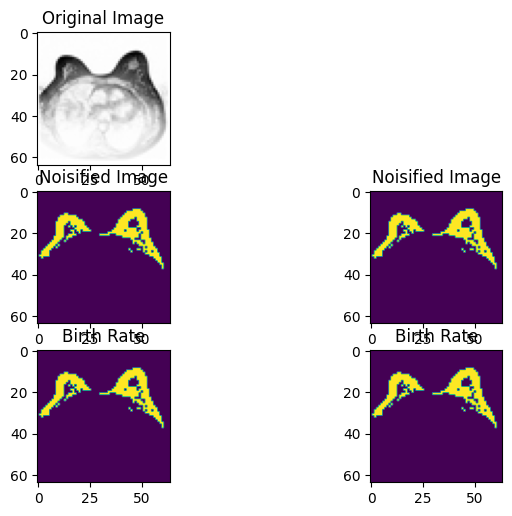

In [388]:
# Blackout Diffusion Process Initialization
diff = BlackoutDiffusion(settings)
real_img = data[0].unsqueeze(0).unsqueeze(4).swapaxes(1,3).swapaxes(1,2)         # [batch_size, width, height, num_slice, num_channel]
noise_img, birth_rate, ts_idx = diff.add_noise(real_img, ts = settings.num_ts)
#noise_img, birth_rate, ts_idx = generateBatchDataGPU(real_img, T = settings.num_ts)

# Image Visualization
num_slice = 15; br_rate = birth_rate[0, 0, num_slice, :, :].numpy()
out_img = ((noise_img[0, 0, num_slice, :, :] * 255.0 + 1.0) / 2.0).numpy().astype('int32')
plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
plt.subplot(3, 2, 1, title = "Original Image")
plt.imshow(data[0, num_slice, :, :], cmap = plt.cm.binary)
plt.subplot(3, 2, 3, title = "Noisified Image")
plt.imshow(out_img)#, cmap = plt.cm.binary)
plt.subplot(3, 2, 4, title = "Noisified Image")
plt.imshow(out_img / np.amax(out_img))#, cmap = plt.cm.binary)
plt.subplot(3, 2, 5, title = "Birth Rate")
plt.imshow(br_rate)#, cmap = plt.cm.binary)
plt.subplot(3, 2, 6, title = "Birth Rate")
plt.imshow((br_rate - np.amin(br_rate)) / (np.amax(br_rate) - np.amin(br_rate)))#, cmap = plt.cm.binary)

# 3D Blackout Diffusion Process Initialization (WIP)
#img = torch.randn(1, 64, 64, 30, 1)
#noise_img, birth_rate, ts_idx = diff.add_noise(img, ts = settings.num_ts)
#noise_img, birth_rate, ts_idx = diff.add_noise(data.unsqueeze(4), ts = settings.num_ts)                                # [batch_size, width, height, num_slice, num_channel]
#noise_img, birth_rate, ts_idx = generateBatchDataGPU(data[0, 15].unsqueeze(0).unsqueeze(3), T = settings.num_ts)       # [batch_size, width, height, num_channel]
#noise_img, birth_rate, ts_idx = generateBatchDataGPU(img, T = settings.num_ts)
